In [1]:
import os
import pickle
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
from PcmPy.tmp__inference_cka import fit_CKA_individ, fit_CKA_group_crossval
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Make monkey avg-across-time dataframe

In [90]:
conditionID = [100, 101, 110, 111, 200, 201, 210, 211]
conditionName = ['RforBot','RforTop','RrevBot', 'RrevTop', 'LforBot','LforTop','LrevBot', 'LrevTop']

# load monkey data:
monk1 = pd.read_csv(os.path.join(analysisDir, 'monk1_avg.csv'))
Y1 = monk1.values
monk2 = pd.read_csv(os.path.join(analysisDir, 'monk2_avg.csv'))
Y2 = monk2.values

Y = {'monk1': Y1, 'monk2': Y2}
neurons_monk = {'monk1_left': np.arange(0,263), 'monk1_right': np.arange(263,263+270), 'monk2_left': np.arange(0,330), 'monk2_right': np.arange(330,330+279)}

df = {'monk': [], 'hem': [], 'cond': [], 'lateral':[], 'hand': [], 'direction': [], 'startPos': [], 'FR': [], 'meanFR': []}

for m in ['monk1', 'monk2']:
    Y_monk = Y[m]
    for h, hem in enumerate(['left', 'right']):
        if hem == 'left':
            neurons = neurons_monk[f'{m}_left']
        else:
            neurons = neurons_monk[f'{m}_right']
        Y_hem = Y_monk[:, neurons]
        for c, cond in enumerate(conditionName):
            hand = 'R' if cond[0] == 'R' else 'L'
            direction = 'forward' if 'for' in cond else 'reverse'
            startPos = 'Top' if 'Top' in cond else 'Bottom'
            contra = 'contra' if ( (hem == 'left' and hand == 'R') or (hem == 'right' and hand == 'L') ) else 'ipsi'

            # change cond name to contra/ipsi:
            if contra == 'contra':
                # replace first letter with C
                cond = list(cond)
                cond[0] = 'C'
                cond = ''.join(cond)
            else:
                cond = list(cond)
                cond[0] = 'I'
                cond = ''.join(cond)
            
            FR_values = Y_hem[c, :]
            df['monk'].append(m)
            df['hem'].append('rhem' if hem == 'right' else 'lhem')
            df['cond'].append(cond)
            df['lateral'].append(contra)
            df['hand'].append(hand)
            df['direction'].append(direction)
            df['startPos'].append(startPos)
            df['FR'].append(FR_values)
            df['meanFR'].append(np.mean(FR_values))
df = pd.DataFrame(df)
df.to_pickle(os.path.join(analysisDir, 'monk_avgTime.pkl'))



# Make monkey full dataframe

In [95]:
conditionID = [100, 101, 110, 111, 200, 201, 210, 211]
conditionName = ['RforBot', 'RforTop', 'RrevBot', 'RrevTop', 'LforBot', 'LforTop', 'LrevBot', 'LrevTop']

neurons_monk = {'monk1_lhem': np.arange(0,263), 'monk1_rhem': np.arange(263,263+270), 'monk2_lhem': np.arange(0,330), 'monk2_rhem': np.arange(330,330+279)}
df = {'monk': [], 'hem': [], 'cond': [], 'lateral':[], 'hand': [], 'direction': [], 'startPos': [], 'FR': [], 'meanFR': []}

for m in ['monk1', 'monk2']:
    for condName in conditionName:
        file_name = os.path.join(analysisDir, f'{m}_{condName}.csv')
        hand = 'R' if condName[0] == 'R' else 'L'
        direction = 'forward' if 'for' in condName else 'reverse'
        startPos = 'Top' if 'Top' in condName else 'Bottom'
        Y = pd.read_csv(file_name).values
        for h, hem in enumerate(['lhem', 'rhem']):
            neurons = neurons_monk[f'{m}_{hem}']
            Y_hem = Y[:, neurons]
            contra = 'contra' if ( (hem == 'lhem' and hand == 'R') or (hem == 'rhem' and hand == 'L') ) else 'ipsi'

            # change cond name to contra/ipsi:
            if contra == 'contra':
                # replace first letter with C
                cond = list(condName)
                cond[0] = 'C'
                cond = ''.join(cond)
            else:
                cond = list(condName)
                cond[0] = 'I'
                cond = ''.join(cond)
            
            df['monk'].append(m)
            df['hem'].append(hem)
            df['cond'].append(cond)
            df['lateral'].append(contra)
            df['hand'].append(hand)
            df['direction'].append(direction)
            df['startPos'].append(startPos)
            df['FR'].append(Y_hem)
            df['meanFR'].append(np.mean(Y_hem, axis=1))
df = pd.DataFrame(df)
df.to_pickle(os.path.join(analysisDir, 'monk_timepoints.pkl'))



# AVG time analyses

## Mean activity contra vs ipsi

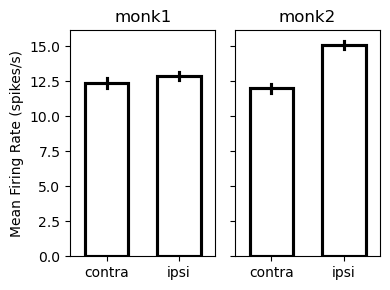

In [3]:
fig, ax = plt.subplots(1,2, figsize=(4,3), sharey=True)
for i, monk in enumerate(['monk1','monk2']) :
    df_tmp = df[df['monk']==monk].copy()
    
    sns.barplot(data=df_tmp, x='lateral', y='meanFR', ax=ax[i], width=0.6, fill=False, color='black')
    ax[i].set_title(f'{monk}')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Mean Firing Rate (spikes/s)')
plt.tight_layout()
plt.show()



## Visualize Covariance matrix

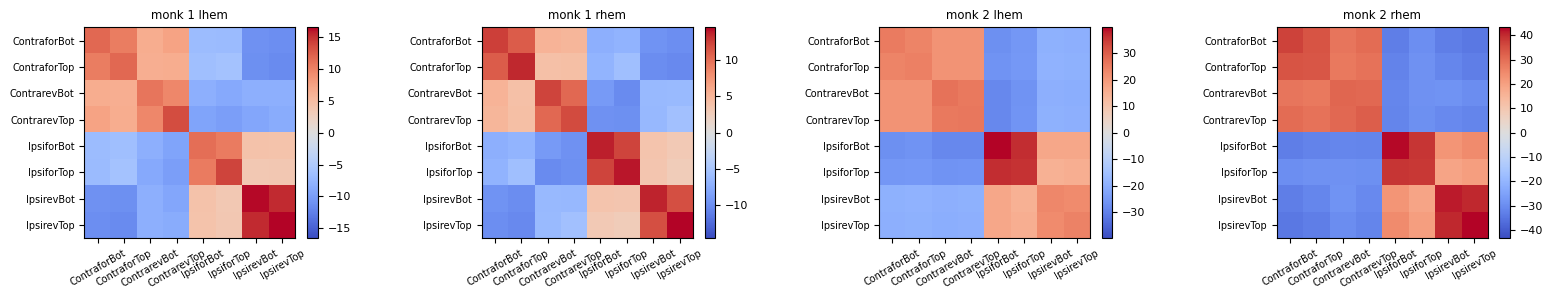

In [ ]:
labels = ['ContraforBot','ContraforTop','ContrarevBot', 'ContrarevTop', 'IpsiforBot','IpsiforTop','IpsirevBot', 'IpsirevTop']

G_hat = np.zeros((4,8,8))

idx = 0
for monk in ['monk1','monk2']:
    for hem in ['lhem', 'rhem']:
        rows = df.loc[((df['monk'] == monk) & (df['hem'] == hem)), 'FR']
        Y_contra = np.vstack(rows[df['lateral']=='contra'].values)
        Y_ipsi = np.vstack(rows[df['lateral']=='ipsi'].values)
        Y = np.vstack([Y_contra, Y_ipsi])
        Y -= np.mean(Y, axis=0, keepdims=True)
        G_hat[idx,:,:] = Y @ Y.T / Y.shape[1]
        idx += 1

plt.rcParams.update({'font.size': 7})
cmap = 'coolwarm'
N = G_hat.shape[0]
fig, ax = plt.subplots(1,N, figsize=(4*N,3))
for i in range(N):
    vmin = -np.max(np.abs(G_hat[i,:,:]))
    vmax = np.max(np.abs(G_hat[i,:,:]))
    ax[i].imshow(G_hat[i],vmin=vmin,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[i], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax[i].set_xticks(np.arange(len(labels)))
    ax[i].set_xticklabels(labels, rotation=30)
    ax[i].set_yticks(np.arange(len(labels)))
    ax[i].set_yticklabels(labels)
    ax[i].set_title(f'monk {i//2+1} {["lhem","rhem"][i%2]}')
plt.tight_layout()
plt.show()



## Pearson r contra-ipsi

In [86]:
labels = ['ContraforBot','ContraforTop','ContrarevBot', 'ContrarevTop', 'IpsiforBot','IpsiforTop','IpsirevBot', 'IpsirevTop']

# overall correlation:
idx = 0
r = []
print('Avergage Correlation:')
for monk in ['monk1','monk2']:
    for hem in ['lhem', 'rhem']:
        rows = df.loc[((df['monk'] == monk) & (df['hem'] == hem)), 'FR']
        Y_contra = np.vstack(rows[df['lateral']=='contra'].values)
        Y_ipsi = np.vstack(rows[df['lateral']=='ipsi'].values)
        
        Y_contra -= np.mean(Y_contra, axis=0, keepdims=True)
        Y_ipsi -= np.mean(Y_ipsi, axis=0, keepdims=True)

        # vectorize:
        Y_contra_vec = Y_contra.flatten()
        Y_ipsi_vec = Y_ipsi.flatten()

        # pearson r:
        r_val = np.corrcoef(Y_contra_vec, Y_ipsi_vec)[0,1]
        print(f'    {monk} {hem} contra-ipsi r: {r_val:.4f}')
        r.append(r_val)
print('\n')

# find the confidence interval for correlation.
# Sampling the neurons with replacement:
# nsample = 1000
# for monk in ['monk1','monk2']:
#     for hem in ['lhem', 'rhem']:
#         rows = df.loc[((df['monk'] == monk) & (df['hem'] == hem)), 'FR']
#         Y_contra = np.vstack(rows[df['lateral']=='contra'].values)
#         Y_ipsi = np.vstack(rows[df['lateral']=='ipsi'].values)
        
#         Y_contra -= np.mean(Y_contra, axis=0, keepdims=True)
#         Y_ipsi -= np.mean(Y_ipsi, axis=0, keepdims=True)


#         # vectorize:
#         Y_contra_vec = Y_contra.flatten()
#         Y_ipsi_vec = Y_ipsi.flatten()

#         # pearson r:
#         r_val = np.corrcoef(Y_contra_vec, Y_ipsi_vec)[0,1]
#         print(f'{monk} {hem} contra-ipsi r: {r_val:.4f}')
#         r.append(r_val)


# permutation test to see if r is significantly different from 0
permutations = 10000
p_values = []
print('Permutation Test:')
for i, monk in enumerate(['monk1','monk2']):
    for j, hem in enumerate(['lhem', 'rhem']):
        rows = df.loc[((df['monk'] == monk) & (df['hem'] == hem)), 'FR']
        Y_contra = np.vstack(rows[df['lateral']=='contra'].values)
        Y_ipsi = np.vstack(rows[df['lateral']=='ipsi'].values)
        
        Y_contra -= np.mean(Y_contra, axis=0, keepdims=True)
        Y_ipsi -= np.mean(Y_ipsi, axis=0, keepdims=True)

        # vectorize:
        Y_contra_vec = Y_contra.flatten()
        Y_ipsi_vec = Y_ipsi.flatten()

        # observed pearson r:
        r_obs = np.corrcoef(Y_contra_vec, Y_ipsi_vec)[0,1]

        # permutation test
        count = 0
        perm_ipsi = Y_ipsi_vec.copy()
        for _ in range(permutations):
            np.random.shuffle(perm_ipsi)
            r_perm = np.corrcoef(Y_contra_vec, perm_ipsi)[0,1]
            if abs(r_perm) >= abs(r_obs):
                count += 1
        p_value = count / permutations
        p_values.append(p_value)
        print(f'    {monk} {hem} contra-ipsi p-value: {p_value:.4f}')
print('\n')




Avergage Correlation:
    monk1 lhem contra-ipsi r: 0.3430
    monk1 rhem contra-ipsi r: 0.3747
    monk2 lhem contra-ipsi r: 0.0588
    monk2 rhem contra-ipsi r: 0.0911


Permutation Test:
    monk1 lhem contra-ipsi p-value: 0.0000
    monk1 rhem contra-ipsi p-value: 0.0000
    monk2 lhem contra-ipsi p-value: 0.0323
    monk2 rhem contra-ipsi p-value: 0.0023




# Timepoints analyses

## mean activity contra vs ipsi

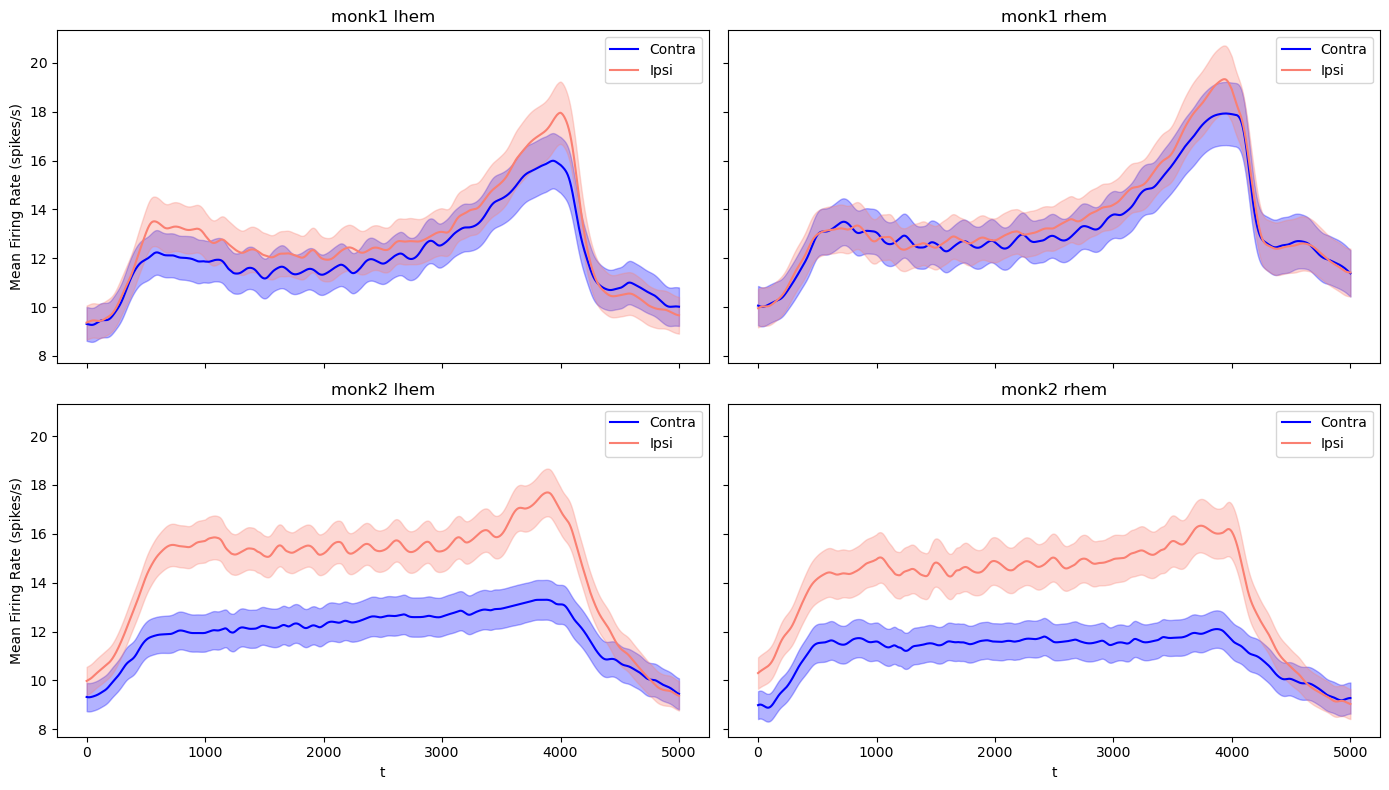

In [ ]:
df = pd.read_pickle(os.path.join(analysisDir, 'monk_timepoints.pkl'))

fig, axes = plt.subplots(2,2, figsize=(14,8), sharey=True, sharex=True)
for i, monk in enumerate(['monk1','monk2']):
    for h, hem in enumerate(['lhem', 'rhem']):
        # contra:
        rows = df.loc[((df['monk'] == monk) & (df['hem'] == hem) & (df['lateral']=='contra')), 'FR'].copy()
        Y_contra = np.mean(rows.values, axis=0) # timepoint X units
        Y_contra_mean = np.mean(Y_contra, axis=1)
        Y_contra_sem = stats.sem(Y_contra, axis=1) # sem across units

        # ipsi:
        rows = df.loc[((df['monk'] == monk) & (df['hem'] == hem) & (df['lateral']=='ipsi')), 'FR'].copy()
        Y_ipsi = np.mean(rows.values, axis=0) # timepoint X units
        Y_ipsi_mean = np.mean(Y_ipsi, axis=1)
        Y_ipsi_sem = stats.sem(Y_ipsi, axis=1) # sem across units

        sns.lineplot(x=np.arange(Y_contra.shape[0]), y=Y_contra_mean, ax=axes[i, h], label='Contra', color='blue')
        axes[i, h].fill_between(np.arange(Y_contra.shape[0]), Y_contra_mean - Y_contra_sem, Y_contra_mean + Y_contra_sem, color='blue', alpha=0.3)
        sns.lineplot(x=np.arange(Y_ipsi.shape[0]), y=Y_ipsi_mean, ax=axes[i, h], label='Ipsi', color='salmon')
        axes[i, h].fill_between(np.arange(Y_ipsi.shape[0]), Y_ipsi_mean - Y_ipsi_sem, Y_ipsi_mean + Y_ipsi_sem, color='salmon', alpha=0.3)
        axes[i, h].set_title(f'{monk} {hem}')
        axes[i, h].set_xlabel('t')
        axes[i, h].set_ylabel('Mean Firing Rate (spikes/s)')
    
plt.tight_layout()
plt.show()



## pearons r contra-ipsi

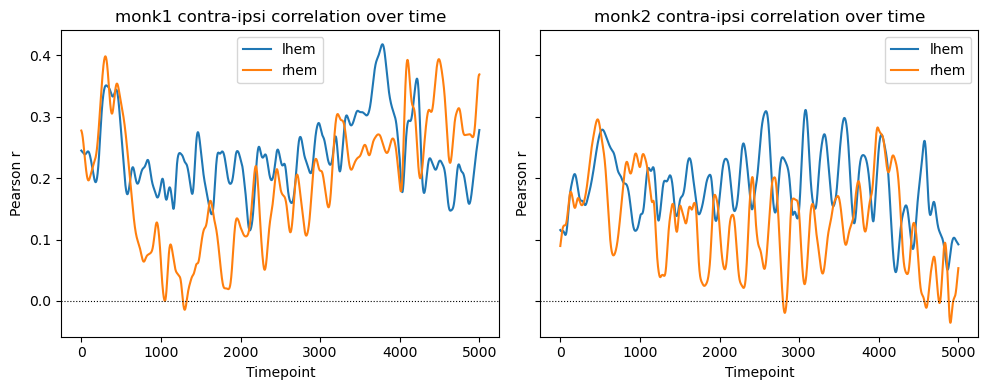

In [15]:
labels = ['ContraforBot','ContraforTop','ContrarevBot', 'ContrarevTop', 'IpsiforBot','IpsiforTop','IpsirevBot', 'IpsirevTop']
df = pd.read_pickle(os.path.join(analysisDir, 'monk_timepoints.pkl'))
nTimepoints = df['FR'].values[0].shape[0]

# overall correlation:
idx = 0
r = []
for monk in ['monk1','monk2']:
    for hem in ['lhem', 'rhem']:
        df_contra = df.loc[((df['monk'] == monk) & (df['hem'] == hem) & (df['lateral']=='contra')),'FR'].copy()
        df_ipsi = df.loc[((df['monk'] == monk) & (df['hem'] == hem) & (df['lateral']=='ipsi')),'FR'].copy()
        r_val = np.zeros(nTimepoints)
        for t in range(nTimepoints):
            Y_contra = np.vstack([row[t,:] for row in df_contra.values])
            Y_ipsi = np.vstack([row[t,:] for row in df_ipsi.values])

            Y_contra -= np.mean(Y_contra, axis=0, keepdims=True)
            Y_ipsi -= np.mean(Y_ipsi, axis=0, keepdims=True)

            # vectorize:
            Y_contra_vec = Y_contra.flatten()
            Y_ipsi_vec = Y_ipsi.flatten()

            # pearson r:
            r_val[t] = np.corrcoef(Y_contra_vec, Y_ipsi_vec)[0,1]
        r.append({'monk': monk, 'hem': hem, 'r': r_val})

# plot r over time:
fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
for i, monk in enumerate(['monk1','monk2']):
    for j, hem in enumerate(['lhem', 'rhem']):
        r_vals = [item['r'] for item in r if item['monk']==monk and item['hem']==hem][0]
        axes[i].plot(np.arange(nTimepoints), r_vals, label=hem)
    axes[i].set_title(f'{monk} contra-ipsi correlation over time')
    axes[i].set_xlabel('Timepoint')
    axes[i].set_ylabel('Pearson r')
    axes[i].legend()
    axes[i].axhline(0, color='black', linestyle=':', linewidth=0.8)
plt.tight_layout()
plt.show()


